In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle
import os
import sys
from numpy import random
import time

# Add QDYN directory to PATH
sys.path.append('/Users/elifo/Desktop/2023_Cycles/qdyn-read-only/src')  # For pyqdyn
sys.path.append('/Users/elifo/Desktop/2023_Cycles/qdyn-read-only/utils/post_processing') # For plot_functions
print(sys.path)
from pyqdyn import qdyn
import plot_functions as qdyn_plot

['/Users/elifo/Desktop/2023_Cycles/qdyn-read-only/examples/elif/10L_damage', '/Users/elifo/Python/Progs', '/Users/elifo/opt/anaconda3/lib/python38.zip', '/Users/elifo/opt/anaconda3/lib/python3.8', '/Users/elifo/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/smtk-0.9.0_gite2e537d-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/openquake.engine-3.10.1-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/scipy-1.4.1-py3.8-macosx-10.9-x86_64.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/requests-2.23.0-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/pyshp-1.2.3-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/psutil-5.6.7-py3.8-macosx-10.9-x86_64.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions',

# Set up the model

In [2]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600.0* 24.0* 365.0    # seconds per year
Lasp = 10                     # Length of asperity (VW) / nucleation length
L = 4                         # Length of model / Lasp
a = 0.014
b = 0.019
resolution = 5                # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 1        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FINITE"] = 1         # 
set_dict["TMAX"] = 10*t_yr      # Maximum simulation time [s]
set_dict["V_PL"] = 1e-9        # Plate velocity
set_dict["MU"] = 3e10          # Shear modulus
set_dict["SIGMA"] = 120e6        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-10         # Solver accuracy
# set_dict["SOLVER"] = 1         # Solver type (Runge-Kutta)

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = a          # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = b          # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 2e-3      # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = 1e-9    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial state [s]

# Damage zone
set_dict['D'] = 0.9 # damage level (delta) = 1- (mu_damage)/ mu_intact_rock 
set_dict['HD'] = 3.0

# Compute relevant length scales:
mu_damage = (1.0- set_dict['D'])* set_dict["MU"]
Lc = 2.0/ np.pi* mu_damage* set_dict["SET_DICT_RSF"]["DC"]* b/  \
                     (set_dict["SIGMA"]* (b-a)** 2.0)
print ('Nucleation length (m): ', Lc)

Lb = 9.0* np.pi/ 32.0* mu_damage* set_dict["SET_DICT_RSF"]["DC"]/ \
                      (set_dict["SIGMA"]* b)
print ('Process zone width (m): ', Lb)

# Length of asperity [m]
Lasp *= Lc
# Fault length [m]
L *= Lasp

print ('VW patch (asperity) size, Lasp (m, Lc): ', Lasp, Lasp/Lc)
print ('Model size, L (m, Lc): ', L, L/Lc)
print ('*')
print ('Damage width ratio, 2h/L_vw: ', 2.0* set_dict['HD']/ Lasp)
print ('Damage level, delta (%): ', 100.0* set_dict['D'])

# Find next power of two for number of mesh elements
N = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
# Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, N, dtype=float)

# Set mesh size and fault length
set_dict["N"] = N
set_dict["L"] = L
# Set time series output node to the middle of the fault
set_dict["IC"] = N // 2

# output settings
set_dict['NXOUT'] = max(1, set_dict['NXOUT']/1024) # Snapshot resolution (every N elements)
set_dict["NTOUT"] = 10                             # Save output every N steps


""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
# outside VW patch, set a = (3b-a) after benjamin's
cdt = (abs(x) > Lasp/ 2.0)
p.mesh_dict["A"][cdt] = 3.0* p.mesh_dict["B"][cdt]- a
print (p.mesh_dict["A"][cdt])

# Write input to qdyn.in
p.write_input()

Nucleation length (m):  24.191551349968098
Process zone width (m):  2.3251919311108664
VW patch (asperity) size, Lasp (m, Lc):  241.91551349968097 10.0
Model size, L (m, Lc):  967.6620539987239 40.0
*
Damage width ratio, 2h/L_vw:  0.02480204726518257
Damage level, delta (%):  90.0
[0.043 0.043 0.043 ... 0.043 0.043 0.043]


True

# Frictional heterogeneity
set by a-parameter variation along fault

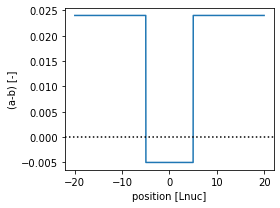

In [3]:
plt.figure(figsize=(4,3))
plt.plot(x/Lc, p.mesh_dict["A"] - p.mesh_dict["B"])
plt.axhline(0, ls=":", c="k")
plt.xlabel("position [Lnuc]")
plt.ylabel("(a-b) [-]")
plt.tight_layout()
# plt.savefig("asperity_a-b.png")
plt.show()

# Quick check of simulation outputs

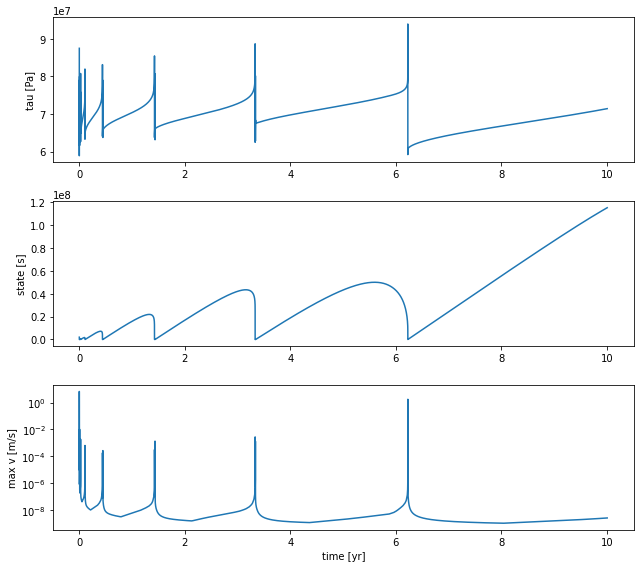

In [4]:
### POST-PROCESS ###
p.read_output()

# Time series of stress, state, and maximum slip rate on the fault
qdyn_plot.timeseries(p.ot[0], p.ot_vmax)

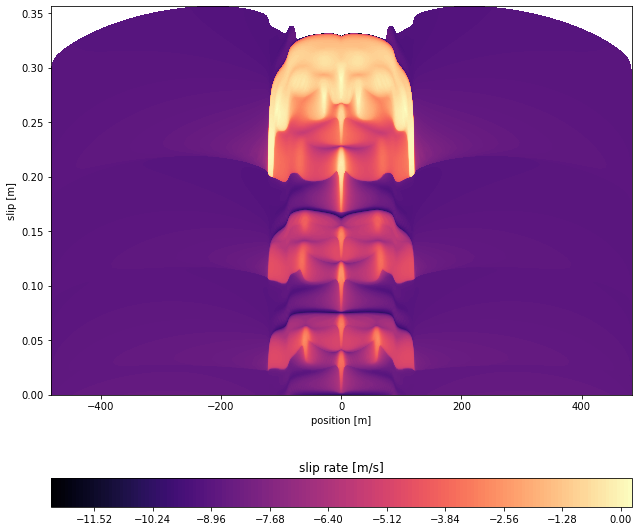

In [5]:
# Spatio-temporal evolution of slip rates
qdyn_plot.slip_profile(p.ox, warm_up=1*t_yr)

In [6]:
p.ox

,t,x,y,z,v,theta,tau,tau_dot,slip,sigma
0,0.000000e+00,-483.712904,0.0,0.0,1.010000e-05,2000000.0,119576700.0,0.0,0.000000,120000000.0
1,0.000000e+00,-483.476659,0.0,0.0,1.010000e-05,2000000.0,119576700.0,0.0,0.000000,120000000.0
2,0.000000e+00,-483.240413,0.0,0.0,1.010000e-05,2000000.0,119576700.0,0.0,0.000000,120000000.0
3,0.000000e+00,-483.004167,0.0,0.0,1.010000e-05,2000000.0,119576700.0,0.0,0.000000,120000000.0
4,0.000000e+00,-482.767922,0.0,0.0,1.010000e-05,2000000.0,119576700.0,0.0,0.000000,120000000.0
...,...,...,...,...,...,...,...,...,...,...
12128251,3.155024e+08,482.767922,0.0,0.0,9.667725e-10,2067885.0,71901740.0,0.0,0.615359,120000000.0
12128252,3.155024e+08,483.004167,0.0,0.0,9.699919e-10,2061118.0,71911420.0,0.0,0.586055,120000000.0
12128253,3.155024e+08,483.240413,0.0,0.0,9.740059e-10,2052738.0,71923440.0,0.0,0.549626,120000000.0
12128254,3.155024e+08,483.476659,0.0,0.0,9.788750e-10,2042659.0,71937950.0,0.0,0.505543,120000000.0


31759012.735866 315502436.45443
data_shape (Nt, Nx): (1067, 4096)
(1067, 4096) (1067, 4096) (1067, 4096)


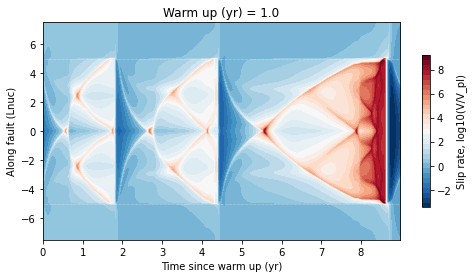

In [7]:
qdyn_plot.plot_2D_slip_rate(p.ox,t_beg=1*t_yr,t_end=max(p.ox['t']),V_pl=1e-9,Lvw=5, Lc=Lc)